## Tech preamble

In [ ]:
from humanfriendly import parse_size

In [2]:
import datetime
from operator import or_
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
from functools import reduce
import tarfile

## How to read and sanitize the data?

In [3]:
def read_host_logs(tar_files):
    """Read CSV files directly from tar archives and concatenate into one large df."""
    
    def _process_tar_archive(tar_file):
        """Read logs from tar archive and look up time stamps in file names."""
        with tarfile.open(tar_file, 'r') as tar:
            log_files = tar.getnames()
            df = pd.concat(
                [
                    pd.read_csv(
                        tar.extractfile(file),
                        delim_whitespace=True
                    ).assign(
                        Time=datetime.datetime.strptime(
                            file.split('.')[0],'%Y-%m-%d-%H-%M-%S'
                        )
                    )
                    for file in log_files
                ]
            )
        return df
    
    # sort file names
    tar_files = sorted(tar_files)
    
    # read tar files and concatenate dataframes
    df = pd.concat(
        [_process_tar_archive(tar_file) for tar_file in tar_files],
        sort=False
    )
    
    # Tidy up data frame.
    mask = df['ExecutionHost'].str.contains('--')
    df = df[~mask]
    
    # Index data by timestamp. (For plotting.)    
    df = df.reset_index()

    return df

In [4]:
def read_request_logs(tar_files):
    
    def _process_tar_archive(tar_file_name):
        """Read logs from tar archive."""
        with tarfile.open(tar_file_name,'r') as tar:
            tar_log_files = tar.getnames()
            df = pd.concat(
                [
                    pd.read_csv(tar.extractfile(file), parse_dates=True)
                    for file in tar_log_files
                ]
            )
        return df
    
    tar_files = sorted(tar_files)
    
    df = pd.concat(
        [_process_tar_archive(tar_file) for tar_file in tar_files],
        sort=False
    )
    
    # Tidy up dataframe
    invalid = [df[col] == "-" for col in df.columns if col != "S"]
    invalid = reduce(or_, invalid)
    df = df[~invalid]
    
    # Parse Memory into Bytes
    df["Memory"] = df["Memory"].apply(parse_size)
        
    df = df.reset_index()
    
    return df

## Find all data files

In [5]:
host_log_tar_files = list(Path("host_logs/").glob("*.tar.gz"))

In [6]:
request_log_tar_files = list(Path("request_logs/").glob("*.tar.gz"))

## Read data

In [7]:
host_df = read_host_logs(host_log_tar_files)
host_df

,index,Free_CPUs,Free_Mem1,Used_CPUs,Cpu,Used_Mem1,ExecutionHost,QueueName,Time,Free_Swap1,Used_Swap1,Load
0,1,0,89447,32,32.0,8527,neshcl218,clbigmem,2020-01-12 18:17:31,NaN,NaN,NaN
1,2,0,77338,32,32.0,20636,neshcl219,clbigmem,2020-01-12 18:17:31,NaN,NaN,NaN
2,3,0,86110,32,31.5,11864,neshcl220,clbigmem,2020-01-12 18:17:31,NaN,NaN,NaN
3,4,0,96897,32,32.0,1077,neshcl221,clbigmem,2020-01-12 18:17:31,NaN,NaN,NaN
4,5,0,77188,32,32.0,20786,neshcl222,clbigmem,2020-01-12 18:17:31,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1293378,201,47,1089,1,0.4,47722,neshve03,"bmtest,veexpress,vequeue,veinteractive",2020-03-03 11:10:25,1002,21,16.3
1293379,202,47,1521,1,0.0,47290,neshve04,"bmtest,veexpress,vequeue,veinteractive",2020-03-03 11:10:25,1011,12,16.1
1293380,203,47,1046,1,0.0,47765,neshve05,"bmtest,veexpress,vequeue,veinteractive",2020-03-03 11:10:25,958,65,16.1
1293381,204,47,6508,1,0.0,42303,neshve06,"bmtest,veexpress,vequeue,veinteractive",2020-03-03 11:10:25,928,95,16.1


In [8]:
request_df = read_request_logs(request_log_tar_files)
request_df

/Users/wrath/miniconda3/envs/nesh-monitoring/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,index,Queue,Pri,STT,S,Memory,CPU,Elapse,R,H,M,Jobs,Identifier,Time
0,0,clbigmem,0,RUN,-,45400000000,10000.9,560223,Y,Y,Y,1,50f38293dabf53e9,2020-02-06 19:53:10.870544
1,1,clbigmem,0,RUN,-,66430000000,1.4615e+06,181504,Y,Y,Y,1,1cadd9af115874fc,2020-02-06 19:53:10.870544
2,2,clbigmem,0,RUN,-,44200000000,2.97369e+06,93235,Y,Y,Y,1,84b513a49a615a33,2020-02-06 19:53:10.870544
3,3,clbigmem,0,RUN,-,2009999999,1.1666e+06,36574,Y,Y,Y,3,817f139219e72642,2020-02-06 19:53:10.870544
4,4,clbigmem,0,RUN,-,30280000000,138056,4353,Y,Y,Y,1,fc3ffa2fca1e77be,2020-02-06 19:53:10.870544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1566195,457,vequeue,0,RUN,-,37410000,7.20,95312,Y,Y,Y,1,254c4161c22d4101,2020-03-03 11:10:32.432433
1566196,458,vequeue,0,RUN,-,430590000,3.63,1052,Y,Y,Y,1,91473da7e5b9aa06,2020-03-03 11:10:32.432433
1566197,459,vequeue,0,QUE,-,0,0.00,0,Y,Y,Y,1,f654123da56fab87,2020-03-03 11:10:32.432433
1566198,460,vequeue,0,QUE,-,0,0.00,0,Y,Y,Y,1,f405e407dc493c5b,2020-03-03 11:10:32.432433


## Have a look

In [30]:
request_df["CPU"] = request_df["CPU"].astype("float")

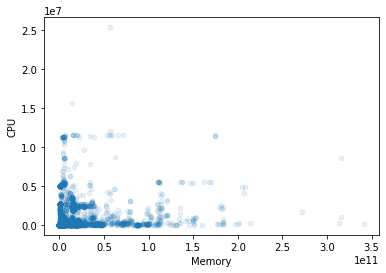

In [45]:
request_df.groupby(["Queue", "Identifier"])[["Memory", "CPU", "Elapse"]].max().plot.scatter(
    x="Memory", y="CPU", alpha=0.1
);